In [1]:
#Loading packages:

import os
import sys
sys.path.append(os.path.join(".."))
from pathlib import Path #Importing Path that we are going to acces our files with.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
#Initialise spacy
nlp = spacy.load("en_core_web_sm") #nlp = natural language processing.
import numpy as np
from tqdm import tqdm

import datetime
from datetime import datetime

In [ ]:
'''
Don't run this code!
'''

#Saving the path to where the data is
data_path = os.path.join("..", "data", "covidvaccine.csv")

#reading data into a dataframe
data = pd.read_csv(data_path)



#Converting the text and date column to string type as some of them are in a float format.
data = data.astype({"text": 'str', "date": 'str'})



'''_________________________________________________________________________'''


# Creating a container for the sentiment scores:
output = []


#The loop runs through the headlines in the csv-file.
for doc in tqdm(nlp.pipe(data["text"], batch_size=200,
                   disable=["tagger", "parser", "ner"]), total = len(data)): #Disabeling to make the code run faster, since there is a lot of data and the processing time is long.
    
    output.append(doc._.sentiment.polarity) #appending the scores to our output container.


# Creating a new dataframe
sentiment_df = pd.DataFrame(data)

# Appending a new series/column to the new df, with the scores
sentiment_df["scores"] = output


#Saving only the columns that is needed in the data set.
sentiment_df = sentiment_df[["date", "text", "scores"]]


'''_______________________________________________________________'''


#creating a container to hold formated time
container = []

#running through the date column
for i in sentiment_df["date"]:
    
    #Appending a sliced time to the container
    container.append(i[:10])
    
#over writing the date column with the values from the container.
sentiment_df["date"] = container

#Write new dataframe out, so it will not have to be processed again.
sentiment_df.to_csv(os.path.join('..', 'data', 'sentiment_scores_twitter2.csv'))

In [2]:
#Adding spaCyTextBlob to spaCy pipline:
spacy_text_blob = SpacyTextBlob()
nlp.add_pipe(spacy_text_blob)

In [3]:
#Saving the path to where the data is
data_path = os.path.join("..", "data", "sentiment_scores_twitter.csv")

#reading data into a dataframe
sentiment_df = pd.read_csv(data_path)

In [4]:
#Dropping all nan's
sentiment_df = sentiment_df.dropna()
#resetting indexes
sentiment_df = sentiment_df.reset_index(drop=True)

In [5]:
#transforming the "date" column from float to string format, to be able to work with the column.
sentiment_df = sentiment_df.astype({"date": 'str'})

In [6]:
#Container to contain errors, that should be deleted later
errors = []

#Container to check what the errors are.
indexes_to_be_dropped =[]

#itterating through the length of sentiment_df.
for i in range (len(sentiment_df)):
    
    current_date = sentiment_df["date"][i]
    
    #If values in this column does not contain "20", I will remove it from det date column.
    if "20" not in current_date:
        errors.append(current_date)
        indexes_to_be_dropped.append(i)

print(f"Errors in the date columns: {errors}")
print(f"The indexes they are ordered by: {indexes_to_be_dropped}")

Errors in the date columns: ["['southafr", "['CovidVac", "['SickleCe", "['CovidVac", "['CovidVac", "['CovidVac", "['CovidVac"]
The indexes they are ordered by: [27429, 64301, 110770, 193224, 259704, 288949, 299647]


In [7]:
#Dropping the errors found above.
sentiment_df = sentiment_df.drop(labels=indexes_to_be_dropped, axis=0).reset_index(drop=True)

#Deleting column.
sentiment_df = sentiment_df.drop('Unnamed: 0', 1)

In [8]:
#Importing datetime in order to rearange the dates into the same format.
import datetime

#Defining a function to guess how the dates should look.
def guess_date(string):
    
    #Running through the different formats
    for fmt in ["%Y-%m-%d", "%d-%m-%Y", "%Y%m%d"]:
        try:
            return datetime.datetime.strptime(string, fmt).date()
        except ValueError:
            continue
    raise ValueError(string)

In [9]:
#container for new time
new_time = []

for time in sentiment_df["date"]:
    #changeing the data format for dates to stand in the same way.
    formated_time = guess_date(time)
    
    # appending the formated_time to the new_time
    new_time.append(formated_time.strftime("%Y%m%d"))
    
#Overwriting date again with the new_time
sentiment_df["date"] = new_time

In [10]:
from datetime import datetime
#creating a container for new date formats
date_formats = []

for date in sentiment_df["date"]:
    #Using the package datetime to transform dates from strings into date format.
    date_time_obj = datetime.strptime(date, '%Y%m%d')
    date_formats.append(date_time_obj)

In [11]:
#over writing the date column with the new list
sentiment_df["date"] = date_formats

#creating the data frame avg_sentiment, grouped by date to make a rolling mean.
avg_sentiment = sentiment_df.groupby("date").mean()
avg_sentiment

,scores
date,
2020-08-09,0.162639
2020-08-10,0.087595
2020-08-11,0.138949
2020-08-12,0.106657
2020-08-13,0.139040
...,...
2021-11-02,0.133490
2021-11-03,0.155355
2021-11-04,0.120189


In [12]:
#calculating rolling mean for weeks.
avg_sentiment['week_rolling_avg'] = avg_sentiment.rolling(7).mean()

In [13]:
avg_sentiment['month_rolling_avg'] = avg_sentiment['scores'].rolling(30).mean()

In [14]:
avg_sentiment

,scores,week_rolling_avg,month_rolling_avg
date,,,
2020-08-09,0.162639,NaN,NaN
2020-08-10,0.087595,NaN,NaN
2020-08-11,0.138949,NaN,NaN
2020-08-12,0.106657,NaN,NaN
2020-08-13,0.139040,NaN,NaN
...,...,...,...
2021-11-02,0.133490,0.131994,0.114224
2021-11-03,0.155355,0.135034,0.116164
2021-11-04,0.120189,0.134277,0.117065


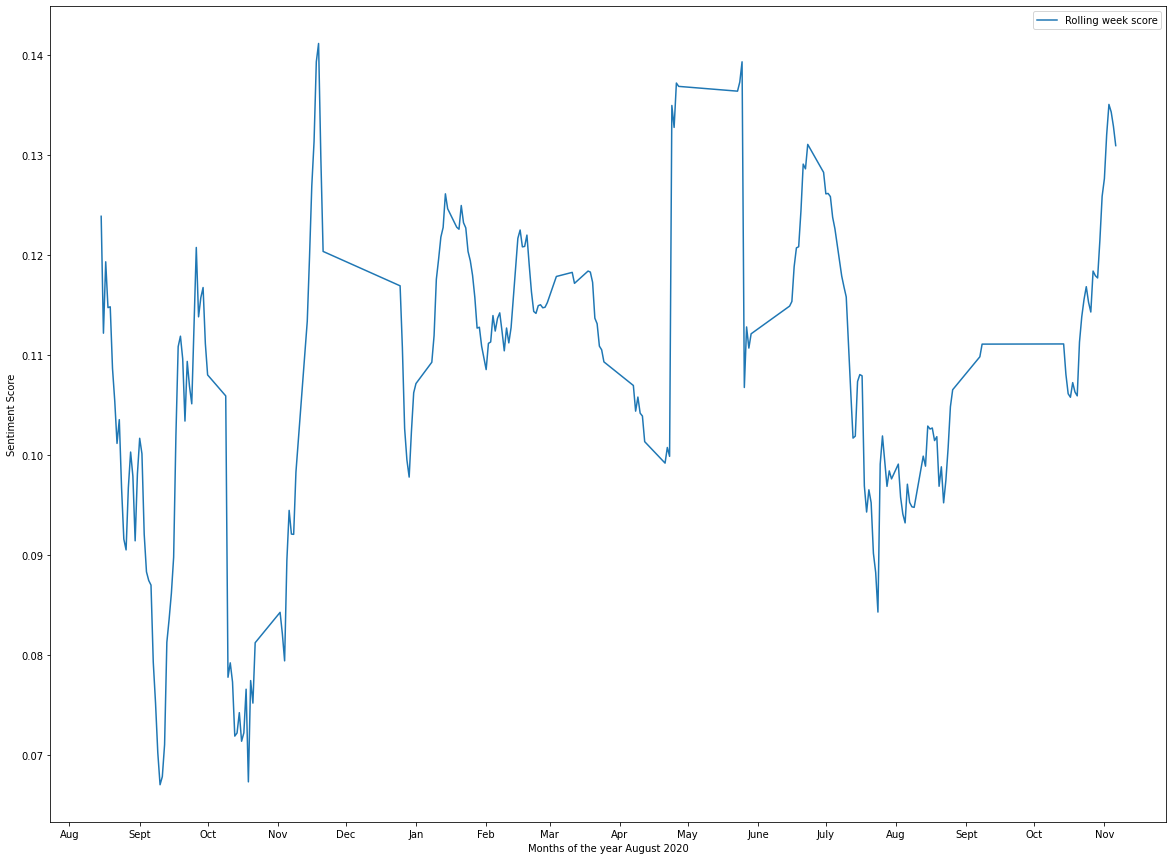

In [58]:
# set figure size
plt.figure( figsize = ( 20, 15))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x = 'date',
             y = 'week_rolling_avg',
             data = avg_sentiment,
             label = 'Rolling week score')

  
plt.xlabel( 'Months of the year August 2020')
  
# setting labels for x axis
pos = ['2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
       '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
       '2021-11-01']
  
# setting labels for x axis
lab = [ 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Jan',
        'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
        'Aug', 'Sept', 'Oct', 'Nov']
  
#plotting
plt.xticks(pos, lab)
  
#plotting
plt.ylabel('Sentiment Score')

plt.savefig(os.path.join("..", "outputs", "RollingWeekGraph.png"))

In [218]:
sentiment_df2['week_rooling_avg'] = sentiment_df2.scores.rolling(7).mean()

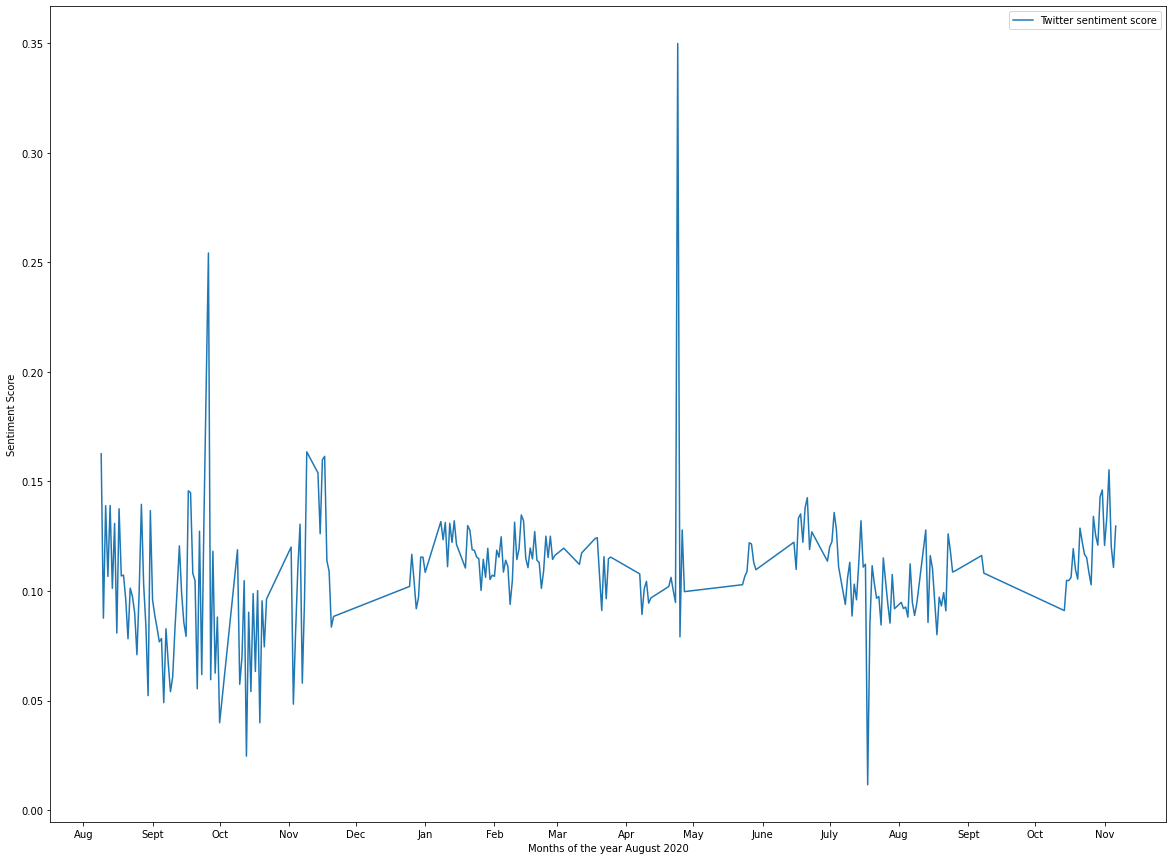

In [59]:
# set figure size
plt.figure( figsize = ( 20, 15))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x = 'date',
             y = 'scores',
             data = avg_sentiment,
             label = 'Twitter sentiment score')
  
plt.xlabel( 'Months of the year August 2020')
  
# setting customized ticklabels for x axis
pos = ['2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
       '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
       '2021-11-01']
  
lab = [ 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Jan',
        'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
        'Aug', 'Sept', 'Oct', 'Nov']
  
plt.xticks(pos, lab)
  
plt.ylabel('Sentiment Score')

plt.savefig(os.path.join("..", "outputs", "DayScoreGraph.png"))

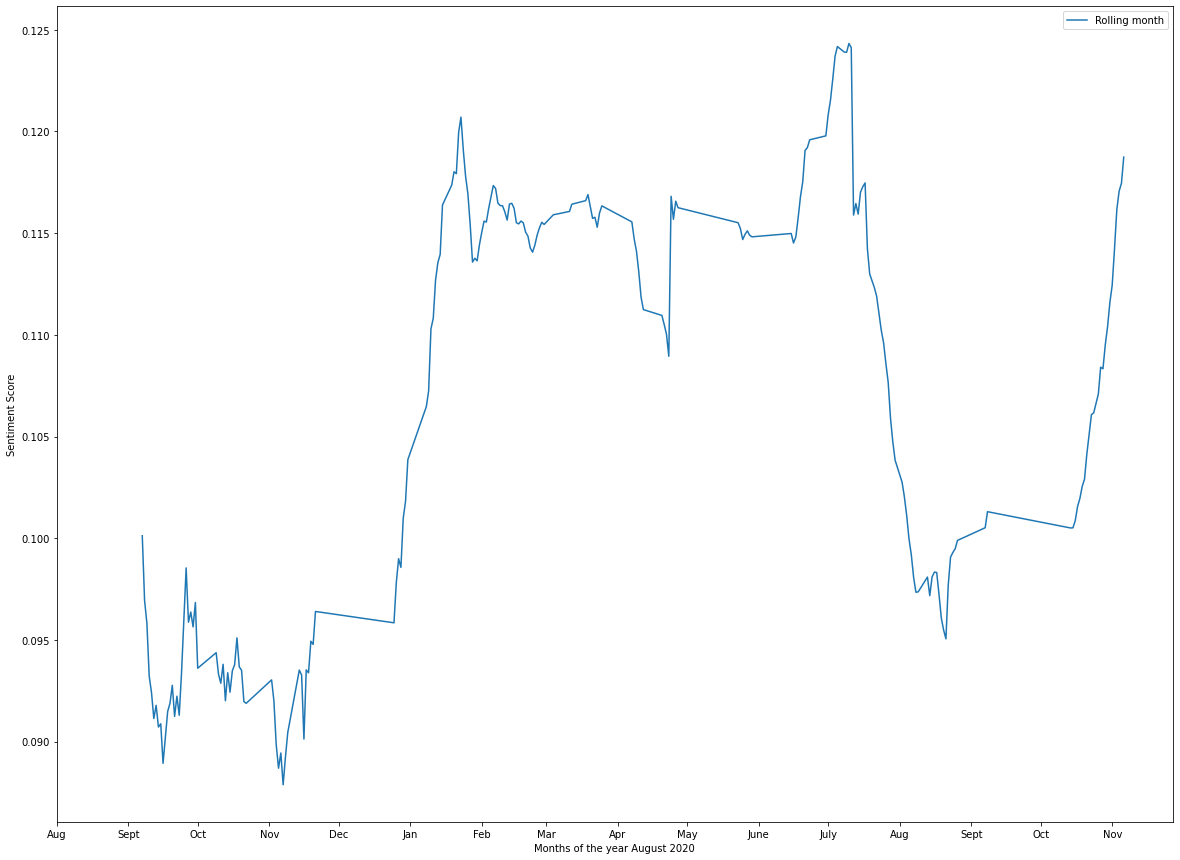

In [60]:
# set figure size
plt.figure( figsize = ( 20, 15))
  
# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot(x = 'date',
             y = 'month_rolling_avg',
             data = avg_sentiment,
             label = 'Rolling month')
  
plt.xlabel( 'Months of the year August 2020')
  
# setting customized ticklabels for x axis
pos = ['2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
       '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
       '2021-11-01']
  
lab = [ 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Jan',
        'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
        'Aug', 'Sept', 'Oct', 'Nov']
  
plt.xticks(pos, lab)
  
plt.ylabel('Sentiment Score')

plt.savefig(os.path.join("..", "outputs", "RollingMonthGraph.png"))

In [25]:
print (avg_sentiment.groupby('scores')['scores'].nlargest(3))

date
2020-08-09    0.162639
2020-08-10    0.087595
2020-08-11    0.138949
2020-08-12    0.106657
2020-08-13    0.139040
                ...   
2021-11-02    0.133490
2021-11-03    0.155355
2021-11-04    0.120189
2021-11-05    0.110750
2021-11-06    0.129654
Name: scores, Length: 258, dtype: float64


In [55]:
avg_sentiment.nsmallest(10, 'week_rolling_avg')

,scores,week_rolling_avg,month_rolling_avg
date,,,
2020-09-10,0.060758,0.067005,0.093219
2020-10-19,0.039844,0.067291,0.093681
2020-09-11,0.082486,0.067815,0.092414
2020-09-09,0.054017,0.070208,0.095826
2020-09-12,0.100741,0.071020,0.091137
2020-10-16,0.098794,0.071354,0.093481
2020-10-13,0.024598,0.071869,0.092013
2020-10-14,0.090300,0.072182,0.093389
2020-10-17,0.063267,0.072193,0.093789


In [54]:
avg_sentiment.nlargest(10, 'week_rolling_avg')

,scores,week_rolling_avg,month_rolling_avg
date,,,
2020-11-19,0.109032,0.141128,0.094937
2021-05-25,0.108867,0.139294,0.114685
2020-11-18,0.113833,0.139291,0.093384
2021-05-24,0.106630,0.137277,0.115225
2021-04-26,0.127888,0.137170,0.116570
2021-04-27,0.099714,0.136837,0.116252
2021-05-23,0.102876,0.136359,0.115513
2021-11-03,0.155355,0.135034,0.116164
2021-04-24,0.350000,0.134928,0.116812


In [29]:
def plot_figure(date, score):
    # set figure size
    plt.figure( figsize = ( 20, 15))

    # plot a simple time series plot
    # using seaborn.lineplot()
    sns.lineplot(x = date,
                 y = score,
                 data = avg_sentiment,
                 label = 'Sentiment score for'+score)


    plt.xlabel( 'Months of the year August 2020', fontsize=25)

    # setting labels for x axis
    pos = ['2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
           '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
           '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
           '2021-11-01']

    # setting labels for x axis
    lab = [ 'Aug', 'Sept', 'Oct', 'Nov', 'Dec','Jan',
            'Feb', 'Mar', 'Apr', 'May', 'June', 'July',
            'Aug', 'Sept', 'Oct', 'Nov']

    #plotting
    plt.xticks(pos, lab)

    #plotting
    plt.ylabel('Sentiment Score', fontsize=25)

    plt.savefig(os.path.join("..", "outputs", score+".png"))

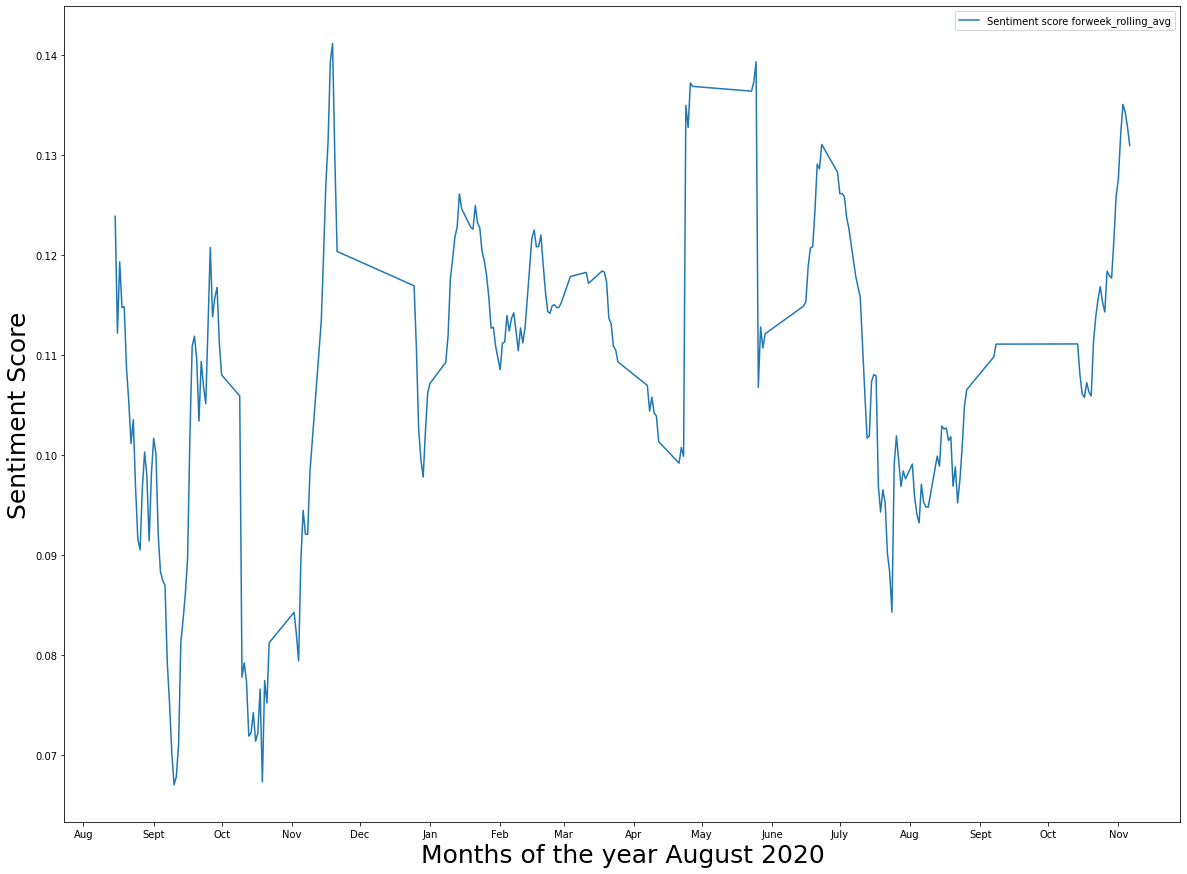

In [30]:
plot_figure('date','week_rolling_avg')

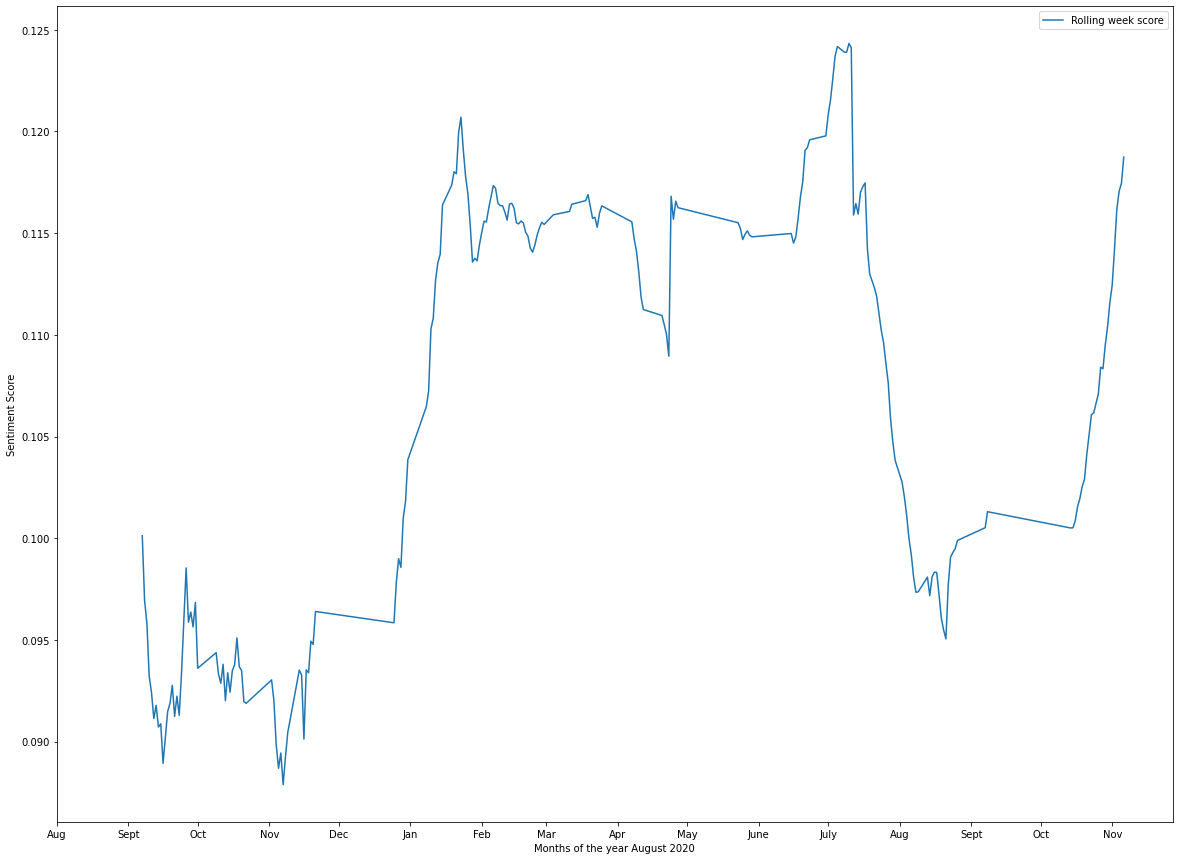

In [17]:
plot_figure('date','month_rolling_avg')

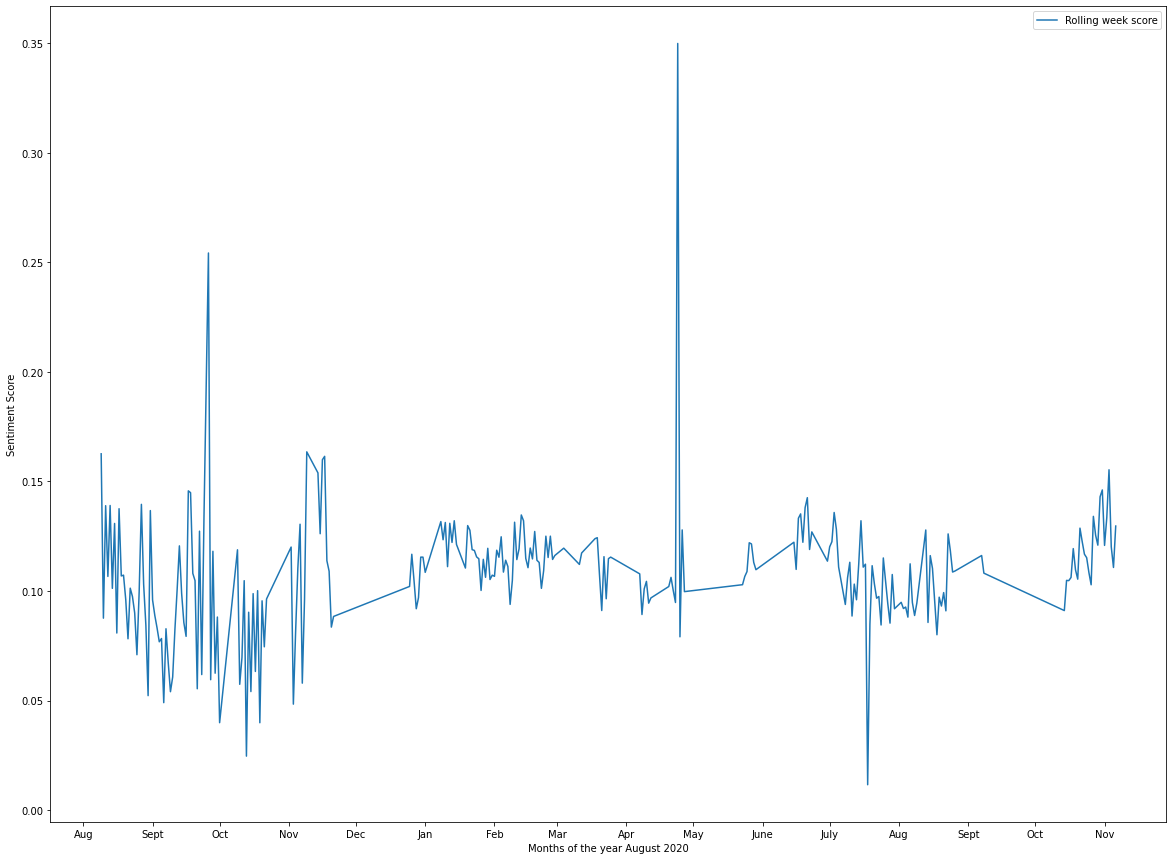

In [18]:
plot_figure('date','scores')